In [2]:
%pip install -r requipython3.10 -m venv venvrements.txt

Note: you may need to restart the kernel to use updated packages.



Usage:   
  c:\Users\switc\AppData\Local\Programs\Python\Python310\python.exe -m pip install [options] <requirement specifier> [package-index-options] ...
  c:\Users\switc\AppData\Local\Programs\Python\Python310\python.exe -m pip install [options] -r <requirements file> [package-index-options] ...
  c:\Users\switc\AppData\Local\Programs\Python\Python310\python.exe -m pip install [options] [-e] <vcs project url> ...
  c:\Users\switc\AppData\Local\Programs\Python\Python310\python.exe -m pip install [options] [-e] <local project path> ...
  c:\Users\switc\AppData\Local\Programs\Python\Python310\python.exe -m pip install [options] <archive url/path> ...

no such option: -m


In [3]:
# Import required libraries
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# Set up paths
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "data", "gestures")
output_dir = "output_coordinates"
models_dir = os.path.join(current_dir, "models")

# Create necessary directories
os.makedirs(data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

In [4]:
def load_all_coordinate_files(output_dir):
    """Load and combine all coordinate CSV files from the output directory
    
    Args:
        output_dir (str): Path to directory containing coordinate CSV files
        
    Returns:
        pandas.DataFrame: Combined DataFrame with all gesture data
        list: List of loaded gesture labels
    """
    print("Loading coordinate files...")
    
    # Get all CSV files except the combined one
    csv_files = [f for f in glob(os.path.join(output_dir, "*.csv")) 
                 if not f.endswith("all_gestures.csv")]
    
    if not csv_files:
        raise FileNotFoundError(
            f"No coordinate CSV files found in {output_dir}. "
            "Please run the data preprocessing notebook first."
        )
    
    # Load each CSV file
    gesture_data = []
    gesture_labels = []
    
    for csv_file in csv_files:
        gesture_name = os.path.splitext(os.path.basename(csv_file))[0]
        print(f"Loading {gesture_name}...")
        
        try:
            df = pd.read_csv(csv_file)
            gesture_data.append(df)
            gesture_labels.append(gesture_name)
            print(f"  - Found {df['image'].nunique()} images")
            print(f"  - Total coordinates: {len(df)}")
        except Exception as e:
            print(f"Error loading {gesture_name}: {str(e)}")
            continue
    
    if not gesture_data:
        raise ValueError("No valid coordinate data could be loaded")
    
    # Combine all DataFrames
    combined_df = pd.concat(gesture_data, ignore_index=True)
    print("\nCombined dataset summary:")
    print(f"Total gestures: {len(gesture_labels)}")
    print(f"Total images: {combined_df['image'].nunique()}")
    print(f"Total coordinates: {len(combined_df)}")
    print(f"Gesture labels: {gesture_labels}")
    
    return combined_df, gesture_labels

In [5]:
def prepare_data(combined_df):
    """Prepare data for model training
    
    Args:
        combined_df (pandas.DataFrame): Combined DataFrame with all gesture data
        
    Returns:
        tuple: (X, y, label_encoder)
    """
    print("Preparing data...")
    
    # Group by image and label
    grouped_data = []
    labels = []
    skipped = 0
    
    for (img, label), group in combined_df.groupby(['image', 'label']):
        # Check if we have exactly 21 points (0-20 for hand landmarks)
        if len(group) != 21:
            skipped += 1
            continue
            
        try:
            # Sort by hand_point to ensure consistent ordering
            sorted_group = group.sort_values('hand_point')
            
            # Verify we have all points from 0-20
            if not all(sorted_group['hand_point'].values == np.arange(21)):
                skipped += 1
                continue
            
            # Extract coordinates in order (x, y, z) for each point
            coords = sorted_group[['x', 'y', 'z']].values
            # Flatten the coordinates to a 1D array
            coords_flat = coords.flatten()
            
            # Verify we have exactly 63 values (21 points * 3 coordinates)
            if len(coords_flat) != 63:
                skipped += 1
                continue
                
            grouped_data.append(coords_flat)
            labels.append(label)
            
        except Exception as e:
            print(f"Error processing image {img}: {str(e)}")
            skipped += 1
            continue
    
    if skipped > 0:
        print(f"Skipped {skipped} images due to missing or invalid points")
    
    if not grouped_data:
        raise ValueError("No valid data could be processed")
    
    # Convert to numpy arrays
    X = np.array(grouped_data)
    
    # Verify shape
    print(f"Data shape: {X.shape}")
    if len(X.shape) != 2 or X.shape[1] != 63:
        raise ValueError(f"Unexpected data shape: {X.shape}, expected (n_samples, 63)")
    
    # Normalize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels)
    
    print(f"Processed {len(X)} valid samples")
    print(f"Features shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    
    return X, y, label_encoder

In [6]:
def augment_data(X, y, noise_factor=0.05, num_augmented=2):
    """Augment data by adding noise and applying small rotations
    
    Args:
        X (numpy.ndarray): Input data
        y (numpy.ndarray): Labels
        noise_factor (float): Amount of noise to add
        num_augmented (int): Number of augmented samples per original sample
        
    Returns:
        tuple: (augmented_X, augmented_y)
    """
    X_aug = [X]
    y_aug = [y]
    
    for _ in range(num_augmented):
        # Add random noise
        noise = np.random.normal(0, noise_factor, X.shape)
        X_noisy = X + noise
        X_aug.append(X_noisy)
        y_aug.append(y)
    
    return np.concatenate(X_aug), np.concatenate(y_aug)

In [7]:
def predict_gesture(model, image_path, label_encoder, detector):
    """Predict gesture from a single image"""
    # Process image
    coords = process_single_image(image_path, "prediction", visualize=True)
    
    if not coords:
        return "No hand detected"
    
    # Prepare input
    X = np.array([np.concatenate([coord['x'], coord['y'], coord['z']] 
                                for coord in coords)])
    
    # Reshape if needed
    if isinstance(model.layers[0], LSTM) or isinstance(model.layers[0], Conv1D):
        X = X.reshape(X.shape[0], 21, 3)
    
    # Make prediction
    pred = model.predict(X)
    pred_class = label_encoder.classes_[np.argmax(pred)]
    confidence = np.max(pred)
    
    return pred_class, confidence

def visualize_prediction(image_path, pred_class, confidence):
    """Visualize the prediction results"""
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title(f'Predicted Gesture: {pred_class}\nConfidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()

In [8]:
def create_dense_model(input_shape, num_classes):
    """Create a dense neural network model"""
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

def create_lstm_model(input_shape, num_classes):
    """Create an LSTM model"""
    model = Sequential([
        LSTM(128, input_shape=(21, 3), return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

def create_cnn_model(input_shape, num_classes):
    """Create a 1D CNN model"""
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(21, 3)),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [9]:
def perform_cross_validation(X, y, model_type='dense', n_splits=5):
    """Perform k-fold cross-validation
    
    Args:
        X (numpy.ndarray): Input data
        y (numpy.ndarray): Labels
        model_type (str): Type of model to use ('dense', 'lstm', or 'cnn')
        n_splits (int): Number of folds
        
    Returns:
        list: List of validation scores
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        print(f"\nFold {fold}/{n_splits}")
        
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]
        
        # Reshape data if needed
        if model_type in ['lstm', 'cnn']:
            X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], 21, 3)
            X_val_fold = X_val_fold.reshape(X_val_fold.shape[0], 21, 3)
        
        # Create and train model
        if model_type == 'dense':
            model = create_dense_model(X_train_fold.shape[1], len(np.unique(y)))
        elif model_type == 'lstm':
            model = create_lstm_model(X_train_fold.shape[1], len(np.unique(y)))
        else:  # CNN
            model = create_cnn_model(X_train_fold.shape[1], len(np.unique(y)))
        
        model.fit(X_train_fold, to_categorical(y_train_fold),
                 epochs=30,
                 batch_size=32,
                 validation_data=(X_val_fold, to_categorical(y_val_fold)),
                 verbose=0)
        
        # Evaluate
        _, accuracy = model.evaluate(X_val_fold, to_categorical(y_val_fold), verbose=0)
        print(f"Fold {fold} accuracy: {accuracy:.4f}")
        scores.append(accuracy)
    
    print(f"\nMean accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    return scores

In [10]:
def validate_data(combined_df):
    """Validate the data before processing
    
    Args:
        combined_df (pandas.DataFrame): Combined DataFrame with all gesture data
    """
    print("\nValidating data...")
    
    # Check for missing values
    missing = combined_df.isnull().sum()
    if missing.any():
        print("Warning: Found missing values:")
        print(missing[missing > 0])
    
    # Check point distribution
    points_per_image = combined_df.groupby(['image', 'label']).size()
    print(f"\nPoint distribution per image:")
    print(f"Min points: {points_per_image.min()}")
    print(f"Max points: {points_per_image.max()}")
    print(f"Mean points: {points_per_image.mean():.2f}")
    
    # Images with incorrect number of points
    incorrect_points = points_per_image[points_per_image != 21]
    if len(incorrect_points) > 0:
        print(f"\nWarning: Found {len(incorrect_points)} images with != 21 points")
        print("Examples:")
        print(incorrect_points.head())
    
    # Check coordinate ranges
    print("\nCoordinate ranges:")
    for coord in ['x', 'y', 'z']:
        print(f"{coord}: [{combined_df[coord].min():.3f}, {combined_df[coord].max():.3f}]")
    
    return len(incorrect_points)

In [11]:
# Load and prepare data
try:
    print("Loading individual coordinate files...")
    combined_df, gesture_labels = load_all_coordinate_files(output_dir)
    
    # Validate data
    num_incorrect = validate_data(combined_df)
    if num_incorrect > 0:
        print(f"\nNote: {num_incorrect} images will be filtered out due to incorrect number of points")
    
    print("\nPreparing data for model...")
    X, y, label_encoder = prepare_data(combined_df)
    
    print(f"\nPrepared dataset:")
    print(f"Input shape: {X.shape}")
    print(f"Number of classes: {len(label_encoder.classes_)}")
    print(f"Classes: {label_encoder.classes_}")
    
    # Data distribution
    unique_labels, counts = np.unique(y, return_counts=True)
    print("\nClass distribution:")
    for label, count in zip(label_encoder.classes_, counts):
        print(f"{label}: {count} samples")
        
except FileNotFoundError as e:
    print(f"Error: {str(e)}")
    print("Please run the data preprocessing notebook first to generate the coordinate files.")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    print(traceback.format_exc()) 

Loading individual coordinate files...
Loading coordinate files...
Loading A...
  - Found 5279 images
  - Total coordinates: 110859
Loading B...
  - Found 6007 images
  - Total coordinates: 126168
Loading C...
  - Found 4880 images
  - Total coordinates: 104349
Loading D...
  - Found 5973 images
  - Total coordinates: 125496
Loading del...
  - Found 3553 images
  - Total coordinates: 75201
Loading E...
  - Found 5417 images
  - Total coordinates: 113946
Loading F...
  - Found 7484 images
  - Total coordinates: 157815
Loading G...
  - Found 6035 images
  - Total coordinates: 126903
Loading H...
  - Found 5885 images
  - Total coordinates: 124194
Loading I...
  - Found 5719 images
  - Total coordinates: 120120
Loading J...
  - Found 5569 images
  - Total coordinates: 116991
Loading K...
  - Found 6714 images
  - Total coordinates: 141120
Loading L...
  - Found 6591 images
  - Total coordinates: 138684
Loading M...
  - Found 3729 images
  - Total coordinates: 78477
Loading N...
  - Found 

C:\Users\switc\AppData\Local\Temp\ipykernel_2524\656679765.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([X[:, i] for i in range(X.shape[1])], labels=coord_names)


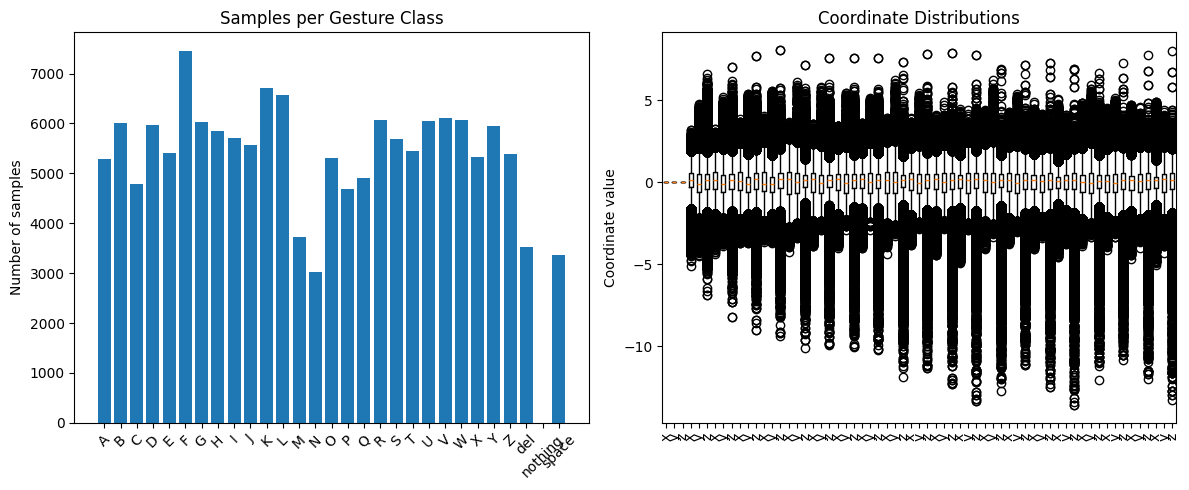

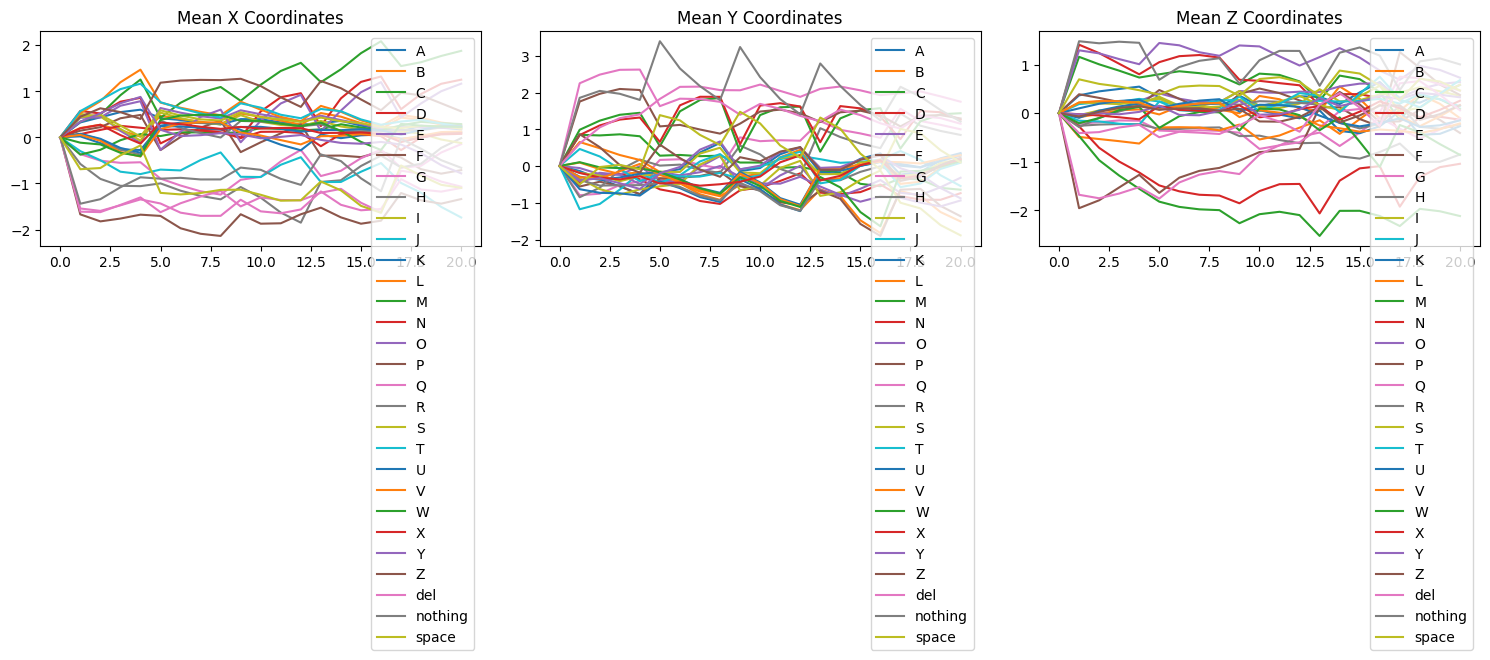

In [12]:
# Visualize data distribution
plt.figure(figsize=(12, 5))

# Plot class distribution
plt.subplot(1, 2, 1)
plt.bar(label_encoder.classes_, counts)
plt.title('Samples per Gesture Class')
plt.xticks(rotation=45)
plt.ylabel('Number of samples')

# Plot coordinate distributions
plt.subplot(1, 2, 2)
coord_names = ['x', 'y', 'z'] * 21  # 21 points, each with x,y,z
plt.boxplot([X[:, i] for i in range(X.shape[1])], labels=coord_names)
plt.title('Coordinate Distributions')
plt.xticks(rotation=90)
plt.ylabel('Coordinate value')

plt.tight_layout()
plt.show()

# Plot mean gesture patterns
plt.figure(figsize=(15, 5))
for i, gesture in enumerate(label_encoder.classes_):
    gesture_data = X[y == i]
    mean_pattern = gesture_data.mean(axis=0)
    
    plt.subplot(1, 3, 1)
    plt.plot(mean_pattern[0::3], label=gesture)  # x coordinates
    plt.title('Mean X Coordinates')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(mean_pattern[1::3], label=gesture)  # y coordinates
    plt.title('Mean Y Coordinates')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(mean_pattern[2::3], label=gesture)  # z coordinates
    plt.title('Mean Z Coordinates')
    plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Augment and split data
print("Augmenting data...")
X_aug, y_aug = augment_data(X, y)
print(f"Original data shape: {X.shape}")
print(f"Augmented data shape: {X_aug.shape}")

# Split data
print("\nSplitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_aug, y_aug, test_size=0.2, random_state=42, stratify=y_aug
)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Augmenting data...
Original data shape: (152028, 63)
Augmented data shape: (456084, 63)

Splitting data into train and test sets...
Training set size: (364867, 63)
Test set size: (91217, 63)


In [14]:
# Perform cross-validation for different models
model_scores = {}

print("Performing cross-validation for different models...")
for model_type in ['dense', 'lstm', 'cnn']:
    print(f"\n{model_type.upper()} Model:")
    scores = perform_cross_validation(X_train, y_train, model_type=model_type)
    model_scores[model_type] = np.mean(scores)

# Select best model
best_model_type = max(model_scores, key=model_scores.get)
print(f"\nBest model: {best_model_type.upper()} (avg score: {model_scores[best_model_type]:.4f})")

Performing cross-validation for different models...

DENSE Model:

Fold 1/5


c:\Users\switc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 accuracy: 0.9837

Fold 2/5
Fold 2 accuracy: 0.9854

Fold 3/5
Fold 3 accuracy: 0.9865

Fold 4/5
Fold 4 accuracy: 0.9842

Fold 5/5
Fold 5 accuracy: 0.9863

Mean accuracy: 0.9852 (+/- 0.0011)

LSTM Model:

Fold 1/5


c:\Users\switc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold 1 accuracy: 0.9943

Fold 2/5
Fold 2 accuracy: 0.9954

Fold 3/5
Fold 3 accuracy: 0.9959

Fold 4/5
Fold 4 accuracy: 0.9951

Fold 5/5
Fold 5 accuracy: 0.9954

Mean accuracy: 0.9952 (+/- 0.0005)

CNN Model:

Fold 1/5


c:\Users\switc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 accuracy: 0.9917

Fold 2/5
Fold 2 accuracy: 0.9935

Fold 3/5
Fold 3 accuracy: 0.9928

Fold 4/5
Fold 4 accuracy: 0.9925

Fold 5/5
Fold 5 accuracy: 0.9923

Mean accuracy: 0.9925 (+/- 0.0006)

Best model: LSTM (avg score: 0.9952)


In [15]:
# Train final model
print(f"\nTraining final {best_model_type.upper()} model...")

# Prepare data based on model type
if best_model_type == 'dense':
    final_model = create_dense_model(X_train.shape[1], len(np.unique(y)))
    X_train_reshaped = X_train
    X_test_reshaped = X_test
else:
    if best_model_type == 'lstm':
        final_model = create_lstm_model(X_train.shape[1], len(np.unique(y)))
    else:  # CNN
        final_model = create_cnn_model(X_train.shape[1], len(np.unique(y)))
    X_train_reshaped = X_train.reshape(X_train.shape[0], 21, 3)
    X_test_reshaped = X_test.reshape(X_test.shape[0], 21, 3)

# Set up model checkpointing
checkpoint_path = os.path.join(models_dir, f'best_model_checkpoint.h5')
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train final model
final_history = final_model.fit(
    X_train_reshaped, to_categorical(y_train),
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        checkpoint
    ],
    verbose=1
)


Training final LSTM model...
Epoch 1/50
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7729 - loss: 0.7469
Epoch 1: val_loss improved from inf to 0.16269, saving model to c:\Users\switc\Documents\ai-project-goonai\models\best_model_checkpoint.h5


9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.7729 - loss: 0.7469 - val_accuracy: 0.9496 - val_loss: 0.1627
Epoch 2/50
9118/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9529 - loss: 0.1581
Epoch 2: val_loss improved from 0.16269 to 0.10251, saving model to c:\Users\switc\Documents\ai-project-goonai\models\best_model_checkpoint.h5


9122/9122 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - accuracy: 0.9529 - loss: 0.1581 - val_accuracy: 0.9690 - val_loss: 0.1025
Epoch 3/50
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9672 - loss: 0.1103
Epoch 3: val_loss improved from 0.10251 to 0.07792, saving model to c:\Users\switc\Documents\ai-project-goonai\models\best_model_checkpoint.h5


9122/9122 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - accuracy: 0.9672 - loss: 0.1103 - val_accuracy: 0.9764 - val_loss: 0.0779
Epoch 4/50
9117/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9750 - loss: 0.0841
Epoch 4: val_loss improved from 0.07792 to 0.06528, saving model to c:\Users\switc\Documents\ai-project-goonai\models\best_model_checkpoint.h5


9122/9122 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - accuracy: 0.9750 - loss: 0.0841 - val_accuracy: 0.9809 - val_loss: 0.0653
Epoch 5/50
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9792 - loss: 0.0693
Epoch 5: val_loss improved from 0.06528 to 0.04895, saving model to c:\Users\switc\Documents\ai-project-goonai\models\best_model_checkpoint.h5


9122/9122 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9792 - loss: 0.0693 - val_accuracy: 0.9854 - val_loss: 0.0489
Epoch 6/50
9117/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9817 - loss: 0.0607
Epoch 6: val_loss improved from 0.04895 to 0.04574, saving model to c:\Users\switc\Documents\ai-project-goonai\models\best_model_checkpoint.h5


9122/9122 ━━━━━━━━━━━━━━━━━━━━ 77s 8ms/step - accuracy: 0.9817 - loss: 0.0607 - val_accuracy: 0.9866 - val_loss: 0.0457
Epoch 7/50
9117/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9847 - loss: 0.0520
Epoch 7: val_loss did not improve from 0.04574
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9847 - loss: 0.0520 - val_accuracy: 0.9864 - val_loss: 0.0467
Epoch 8/50
9118/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9860 - loss: 0.0468
Epoch 8: val_loss improved from 0.04574 to 0.04054, saving model to c:\Users\switc\Documents\ai-project-goonai\models\best_model_checkpoint.h5


9122/9122 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9860 - loss: 0.0468 - val_accuracy: 0.9884 - val_loss: 0.0405
Epoch 9/50
9121/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9870 - loss: 0.0436
Epoch 9: val_loss improved from 0.04054 to 0.03327, saving model to c:\Users\switc\Documents\ai-project-goonai\models\best_model_checkpoint.h5


9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9870 - loss: 0.0436 - val_accuracy: 0.9900 - val_loss: 0.0333
Epoch 10/50
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9883 - loss: 0.0389
Epoch 10: val_loss improved from 0.03327 to 0.03168, saving model to c:\Users\switc\Documents\ai-project-goonai\models\best_model_checkpoint.h5


9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9883 - loss: 0.0389 - val_accuracy: 0.9904 - val_loss: 0.0317
Epoch 11/50
9116/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9892 - loss: 0.0355
Epoch 11: val_loss improved from 0.03168 to 0.02402, saving model to c:\Users\switc\Documents\ai-project-goonai\models\best_model_checkpoint.h5


9122/9122 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - accuracy: 0.9892 - loss: 0.0355 - val_accuracy: 0.9931 - val_loss: 0.0240
Epoch 12/50
9119/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9899 - loss: 0.0333
Epoch 12: val_loss did not improve from 0.02402
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - accuracy: 0.9899 - loss: 0.0333 - val_accuracy: 0.9912 - val_loss: 0.0290
Epoch 13/50
9117/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9901 - loss: 0.0325
Epoch 13: val_loss did not improve from 0.02402
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - accuracy: 0.9901 - loss: 0.0325 - val_accuracy: 0.9919 - val_loss: 0.0265
Epoch 14/50
9118/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9905 - loss: 0.0313
Epoch 14: val_loss did not improve from 0.02402
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9905 - loss: 0.0313 - val_accuracy: 0.9920 - val_loss: 0.0260
Epoch 15/50
9119/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9912 - loss: 0.0297
Epoch 15: val_loss d

9122/9122 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9922 - loss: 0.0254 - val_accuracy: 0.9938 - val_loss: 0.0202
Epoch 19/50
9118/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9927 - loss: 0.0239
Epoch 19: val_loss did not improve from 0.02025
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9927 - loss: 0.0239 - val_accuracy: 0.9931 - val_loss: 0.0241
Epoch 20/50
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9926 - loss: 0.0241
Epoch 20: val_loss improved from 0.02025 to 0.01848, saving model to c:\Users\switc\Documents\ai-project-goonai\models\best_model_checkpoint.h5


9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9926 - loss: 0.0241 - val_accuracy: 0.9944 - val_loss: 0.0185
Epoch 21/50
9118/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9936 - loss: 0.0223
Epoch 21: val_loss did not improve from 0.01848
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9936 - loss: 0.0223 - val_accuracy: 0.9937 - val_loss: 0.0210
Epoch 22/50
9118/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9935 - loss: 0.0213
Epoch 22: val_loss did not improve from 0.01848
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9935 - loss: 0.0213 - val_accuracy: 0.9943 - val_loss: 0.0199
Epoch 23/50
9116/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9935 - loss: 0.0223
Epoch 23: val_loss improved from 0.01848 to 0.01770, saving model to c:\Users\switc\Documents\ai-project-goonai\models\best_model_checkpoint.h5


9122/9122 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.9935 - loss: 0.0223 - val_accuracy: 0.9951 - val_loss: 0.0177
Epoch 24/50
9121/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9938 - loss: 0.0205
Epoch 24: val_loss did not improve from 0.01770
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9938 - loss: 0.0205 - val_accuracy: 0.9942 - val_loss: 0.0203
Epoch 25/50
9117/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9939 - loss: 0.0199
Epoch 25: val_loss did not improve from 0.01770
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9939 - loss: 0.0199 - val_accuracy: 0.9943 - val_loss: 0.0215
Epoch 26/50
9119/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9943 - loss: 0.0191
Epoch 26: val_loss did not improve from 0.01770
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9943 - loss: 0.0191 - val_accuracy: 0.9948 - val_loss: 0.0190
Epoch 27/50
9118/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9942 - loss: 0.0189
Epoch 27: val_loss d

9122/9122 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9943 - loss: 0.0197 - val_accuracy: 0.9953 - val_loss: 0.0173
Epoch 29/50
9120/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9940 - loss: 0.0199
Epoch 29: val_loss did not improve from 0.01728
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9940 - loss: 0.0199 - val_accuracy: 0.9937 - val_loss: 0.0226
Epoch 30/50
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9940 - loss: 0.0194
Epoch 30: val_loss did not improve from 0.01728
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9940 - loss: 0.0194 - val_accuracy: 0.9946 - val_loss: 0.0208
Epoch 31/50
9118/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9949 - loss: 0.0168
Epoch 31: val_loss did not improve from 0.01728
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9949 - loss: 0.0168 - val_accuracy: 0.9950 - val_loss: 0.0184
Epoch 32/50
9117/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9949 - loss: 0.0165
Epoch 32: val_loss d

9122/9122 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9950 - loss: 0.0170 - val_accuracy: 0.9952 - val_loss: 0.0162
Epoch 34/50
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9949 - loss: 0.0167
Epoch 34: val_loss did not improve from 0.01623
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9949 - loss: 0.0167 - val_accuracy: 0.9945 - val_loss: 0.0189
Epoch 35/50
9117/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9948 - loss: 0.0169
Epoch 35: val_loss did not improve from 0.01623
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9948 - loss: 0.0169 - val_accuracy: 0.9949 - val_loss: 0.0188
Epoch 36/50
9116/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9953 - loss: 0.0161
Epoch 36: val_loss did not improve from 0.01623
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.9953 - loss: 0.0161 - val_accuracy: 0.9945 - val_loss: 0.0226
Epoch 37/50
9116/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9952 - loss: 0.0165
Epoch 37: val_loss d

9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9954 - loss: 0.0151 - val_accuracy: 0.9958 - val_loss: 0.0152
Epoch 39/50
9119/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9953 - loss: 0.0161
Epoch 39: val_loss did not improve from 0.01523
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9953 - loss: 0.0161 - val_accuracy: 0.9953 - val_loss: 0.0169
Epoch 40/50
9121/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9955 - loss: 0.0142
Epoch 40: val_loss did not improve from 0.01523
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9955 - loss: 0.0142 - val_accuracy: 0.9951 - val_loss: 0.0181
Epoch 41/50
9120/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9953 - loss: 0.0154
Epoch 41: val_loss did not improve from 0.01523
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9953 - loss: 0.0154 - val_accuracy: 0.9947 - val_loss: 0.0208
Epoch 42/50
9117/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9955 - loss: 0.0147
Epoch 42: val_loss d

9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9956 - loss: 0.0142 - val_accuracy: 0.9958 - val_loss: 0.0149
Epoch 47/50
9121/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9955 - loss: 0.0146
Epoch 47: val_loss did not improve from 0.01488
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9955 - loss: 0.0146 - val_accuracy: 0.9956 - val_loss: 0.0167
Epoch 48/50
9117/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9958 - loss: 0.0144
Epoch 48: val_loss did not improve from 0.01488
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9958 - loss: 0.0144 - val_accuracy: 0.9961 - val_loss: 0.0155
Epoch 49/50
9121/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9962 - loss: 0.0134
Epoch 49: val_loss did not improve from 0.01488
9122/9122 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9962 - loss: 0.0134 - val_accuracy: 0.9957 - val_loss: 0.0165
Epoch 50/50
9120/9122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9961 - loss: 0.0136
Epoch 50: val_loss d

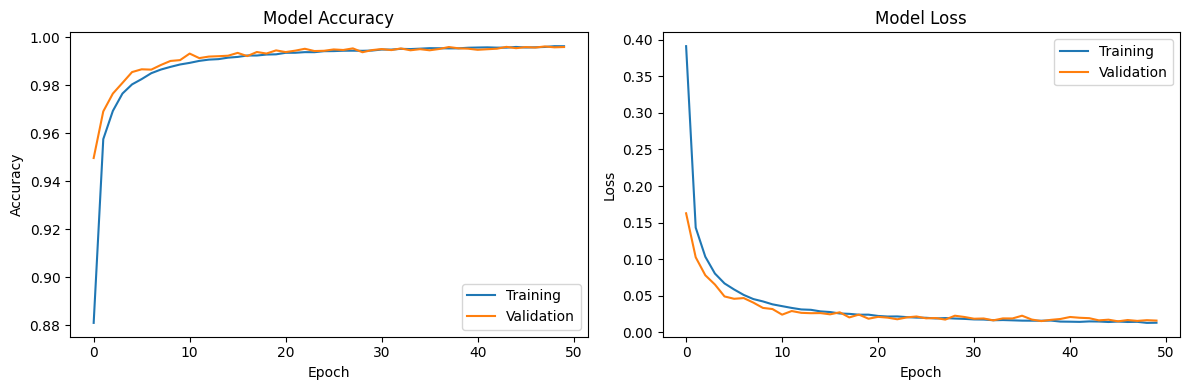

In [16]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'], label='Training')
plt.plot(final_history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'], label='Training')
plt.plot(final_history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

2851/2851 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           A       0.99      1.00      1.00      3167
           B       1.00      1.00      1.00      3604
           C       1.00      0.99      1.00      2875
           D       1.00      1.00      1.00      3582
           E       0.99      1.00      0.99      3245
           F       1.00      1.00      1.00      4472
           G       1.00      1.00      1.00      3616
           H       1.00      1.00      1.00      3514
           I       0.99      1.00      1.00      3431
           J       1.00      1.00      1.00      3340
           K       1.00      1.00      1.00      4025
           L       1.00      1.00      1.00      3947
           M       0.99      0.98      0.98      2232
           N       0.98      0.98      0.98      1817
           O       1.00      0.99      1.00      3187
           P       1.00      1.00      1.00      2813
           Q   

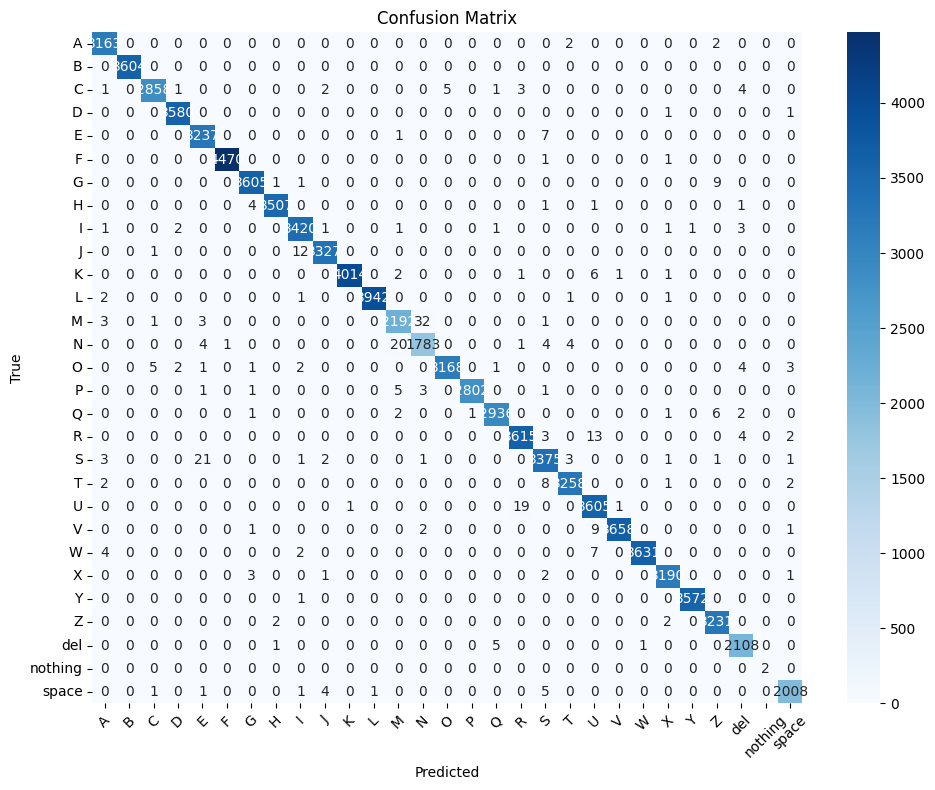

In [17]:
# Evaluate model on test set
y_pred = final_model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Save final model and label encoder
model_path = os.path.join(models_dir, f'hand_gesture_model_{best_model_type}.h5')
encoder_path = os.path.join(models_dir, 'label_encoder_classes.npy')

final_model.save(model_path)
np.save(encoder_path, label_encoder.classes_)

print(f"Model saved to: {model_path}")
print(f"Label encoder saved to: {encoder_path}")

Model saved to: c:\Users\switc\Documents\ai-project-goonai\models\hand_gesture_model_lstm.h5
Label encoder saved to: c:\Users\switc\Documents\ai-project-goonai\models\label_encoder_classes.npy
